In [3]:
!pip install transformers
!pip install sentencepiece 

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 33.3 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 895 kB 38.2 MB/s 
     |████████████████████████████████| 596 kB 37.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.7 MB/s 


In [4]:
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
from torch import nn


tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
model_bert = AutoModel.from_pretrained('ai4bharat/indic-bert')


Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'sop_classifier.classifier.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'sop_classifier.classifier.weight', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
device = torch.device("cuda")

In [7]:
f=open('hi_train.conll') 
train_data = f.readlines()
f.close()

f1=open('hi_dev.conll') 
test_data = f1.readlines()
f1.close()

 

In [8]:
dataset = {}
dataset_test= {}
unique_tag=set()
def find_unique_tag(text,text_test):
    for i in range(len(text)) :
        if text[i].split(' ')[0]=="#" or text[i].split(" ")[-1][:-1]=='':
          continue
        else :
            dataset[text[i].split(" ")[0]]= text[i].split(" ")[-1][:-1]
            temp  =text[i].split(" ")[-1][:-1]
            unique_tag.add(temp)

    for i in range(len(text_test)) :
        if text_test[i].split(' ')[0]=="#" or text_test[i].split(" ")[-1][:-1]=='':
          continue
        else :
            dataset_test[text_test[i].split(" ")[0]]= text_test[i].split(" ")[-1][:-1]
            temp  =text_test[i].split(" ")[-1][:-1]
            unique_tag.add(temp)
    return unique_tag



In [9]:
u_t=find_unique_tag(train_data,test_data)
len(u_t)

13

In [10]:
#code to check  the unique tags 
class_to_idx = {}
i=0
for a in unique_tag:
  class_to_idx[a]=i 
  i+=1

class_to_idx

{'B-CORP': 8,
 'B-CW': 6,
 'B-GRP': 9,
 'B-LOC': 2,
 'B-PER': 1,
 'B-PROD': 7,
 'I-CORP': 4,
 'I-CW': 3,
 'I-GRP': 5,
 'I-LOC': 10,
 'I-PER': 0,
 'I-PROD': 12,
 'O': 11}

In [11]:

labels = torch.zeros((len(dataset) , 13))
#Getting training labels 
def get_labels():
  train_input = []
  idx = 0 
  # extracting each key from the dataset and storing into list to create training data list 
  for keys in dataset : 
      train_input.append(keys)
      labels[idx, class_to_idx[dataset[keys]]] = 1
      idx+=1
  return train_input

len(labels)    

29338

In [12]:
inputs = get_labels()

In [13]:
labels_test = torch.zeros((len(dataset_test) , 13))
def get_test_labels():
  inputs_test = []
  idx = 0 
  for keys in dataset_test : 
      inputs_test.append(keys)
      labels_test[idx, class_to_idx[dataset_test[keys]]] = 1
      idx+=1
  return inputs_test

In [14]:
inputs_test = get_test_labels()

In [15]:
split_ratio = 0.7
train_size = int(len(dataset)*split_ratio)
train_size

20536

In [16]:
#Loading all the training dataset 
inputs_train = inputs
labels_train = labels
# loading all the test datatest
inputs_val = inputs_test
labels_val = labels_test


In [17]:
max_seq_len = 13

In [18]:
word = ['राजनीतिक']
id_to_be_sent = tokenizer.batch_encode_plus(word, truncation = True, return_token_type_ids=False)
id_to_be_sent

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[2, 34886, 339, 31638, 3]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [19]:
train_sent_id = tokenizer.batch_encode_plus(inputs_train,max_length = max_seq_len, truncation = True, padding=True, return_token_type_ids=False)
val_sent_id = tokenizer.batch_encode_plus(inputs_val, max_length = max_seq_len, truncation = True,padding=True, return_token_type_ids=False)

In [20]:
#loading for training set
train_seq = torch.tensor(train_sent_id['input_ids'])
train_mask = torch.tensor(train_sent_id['attention_mask'])


# loading for validation set
val_seq = torch.tensor(val_sent_id['input_ids'])
val_mask = torch.tensor(val_sent_id['attention_mask'])




In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32
print(len(train_seq),' ',len(train_mask),"  ",len(labels_train))
train_data = TensorDataset(train_seq, train_mask, labels_train)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, labels_val)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

29338   29338    29338


In [22]:
for param in model_bert.parameters():
    param.requires_grad = True#False


In [66]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,13)

      #softmax activation function
      self.softmax = nn.Softmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
      val = self.fc1(cls_hs)
      val = self.relu(val)
      val = self.dropout(val)
      # output layer
      val = self.fc2(val)
      # apply relu activation
      val = self.softmax(val)

      return val


In [67]:
model = BERT_Arch(model_bert)

# push the model to GPU
model = model.to(device)

In [68]:
for param in model.parameters():
    param.requires_grad = True


In [69]:
x1,x2 = model_bert(torch.tensor(id_to_be_sent['input_ids']).to(device) , torch.tensor(id_to_be_sent['attention_mask']).to(device))

In [70]:
model_bert(torch.tensor(id_to_be_sent['input_ids']).to(device) , torch.tensor(id_to_be_sent['attention_mask']).to(device))['pooler_output']

tensor([[-0.9995,  1.0000, -1.0000, -0.9998,  0.9885, -0.9996, -0.9950,  1.0000,
         -1.0000, -0.9960,  0.9999, -1.0000, -0.9980,  0.9998, -1.0000, -0.9998,
          0.9978,  0.9999,  1.0000, -0.9973, -0.9998,  0.9998, -0.9999, -1.0000,
         -0.9999,  0.9999, -0.9985,  0.9953, -0.9991,  1.0000, -0.9997,  1.0000,
         -0.9999, -0.9999,  1.0000,  1.0000, -0.9951, -0.9911,  1.0000,  1.0000,
         -1.0000, -0.9992,  0.9760, -0.9981, -0.9983,  0.9998,  0.9996, -0.9995,
          0.8636, -0.9993, -1.0000, -0.9999,  1.0000, -1.0000,  1.0000,  1.0000,
          0.9944, -0.9993,  0.8780, -0.9999,  0.9999, -1.0000, -1.0000,  1.0000,
         -0.9997,  1.0000, -0.9993,  0.9403,  1.0000, -1.0000,  0.9994, -1.0000,
          1.0000, -0.9993,  0.9984,  1.0000,  0.9921,  1.0000,  0.9979, -1.0000,
          0.9844, -1.0000,  0.6400, -0.9720,  0.9997,  1.0000,  1.0000,  1.0000,
          0.9993, -0.9897,  0.9981,  0.9998,  1.0000,  0.9846,  1.0000, -0.9904,
          1.0000, -0.9991, -

In [71]:
model.eval()

BERT_Arch(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(200000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
           

In [72]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 0.045)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [73]:
cross_entropy  = nn.CrossEntropyLoss() 


In [74]:
def training():
  total_loss, total_accuracy = 0, 0
   #batch_idx = 0 
  temp_acc = 0 
  n = 0
  predictions=[]
  acc_preds = [] # empty list to save model predictions
  #start model training
  model.train()
  #while batch_idx <= n : 
  for step,batch in enumerate(train_dataloader): 
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
    sent_id = sent_id.to(device)
    mask = mask.to(device)
    labels = labels.to(device)
    n+= labels.shape[0]
    # clear previously calculated gradients 
    model.zero_grad()    
    #print(type(mask))
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()
    temp_acc += torch.sum(torch.argmax(preds, dim = 1) == torch.argmax(labels, dim =1 ))
    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    predictions.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  acc_preds.append(float(temp_acc/n))
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(predictions, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds,acc_preds

In [75]:
# function for evaluating the model
import time 
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  acc_preds = []
  temp_acc = 0 
  n = 0
  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = 0 # format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    
    sent_id, mask, labels = batch
    n+= labels.shape[0]
    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      temp_acc += torch.sum(torch.argmax(preds, dim = 1) == torch.argmax(labels, dim =1 ))
      
      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 
  acc_preds.append(float(temp_acc/n))
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds,acc_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
epochs = 5
#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, preds, acc_train = training()
    
    #evaluate model
    valid_loss, preds, acc_val = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss:', train_loss, '\t Training Acc = ',acc_train)
    print(f'Validation Loss: ',valid_loss ,' \t Validation Acc = ',acc_val)


 Epoch 1 / 2
  Batch    50  of    917.
  Batch   100  of    917.
  Batch   150  of    917.
  Batch   200  of    917.
  Batch   250  of    917.
  Batch   300  of    917.
  Batch   350  of    917.
  Batch   400  of    917.
  Batch   450  of    917.
  Batch   500  of    917.
  Batch   550  of    917.
  Batch   600  of    917.
  Batch   650  of    917.
  Batch   700  of    917.
  Batch   750  of    917.
  Batch   800  of    917.
  Batch   850  of    917.
  Batch   900  of    917.

Evaluating...
  Batch    50  of    131.
  Batch   100  of    131.

Training Loss: 2.081140332549583 	 Training Acc =  [0.6078464388847351]
Validation Loss:  1.9789622557982234  	 Validation Acc =  [0.7101101875305176]

 Epoch 2 / 2
  Batch    50  of    917.
  Batch   100  of    917.
  Batch   150  of    917.
  Batch   200  of    917.
  Batch   250  of    917.
  Batch   300  of    917.
  Batch   350  of    917.
  Batch   400  of    917.


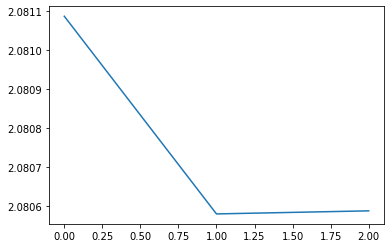

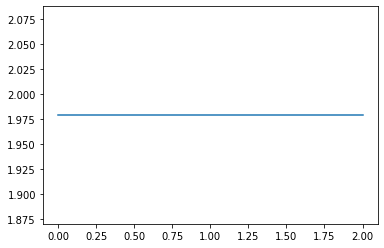

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.show()
plt.plot(valid_losses)
plt.show()